In [1]:
# Additional Code for Colab. Comment out if not using Colab.
# %pip install captum
# Additional Code for Colab. Comment out if not using Colab.

import os, glob
import matplotlib.pyplot as plt

# ..........torch imports............
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# .... Captum imports..................
from captum.attr import LayerIntegratedGradients
from captum.concept import TCAV

# Additional Code for Colab. Comment out if not using Colab.
# from google.colab import drive
# drive.mount('/content/drive')
#
# import sys
# sys.path.append('/content/drive/MyDrive/School/Fall 2022/COMP 5900')
# Additional Code for Colab. Comment out if not using Colab.

# ..........support imports............
from SupportClasses import Data_support as ds
from SupportClasses import TCAV_support as ts
from SupportClasses import Model_support as ms

# GLobal values
COLAB = False
NUM_OF_EPOCHS = 5
CONCEPTS_PATH = "data/tcav/image/concepts/"
DATA_DIR = 'data/tcav/image/imagenet'
# End of Global values


# Modifiable Values
TARGET_CONCEPT = "striped"
TARGET_CLASS = "zebra"
CONCEPUTAL_LOSS_WEIGHT = 0.1
BASELINE_MODEL_PATH = 'baseline-model.pt'
CONCEPTUAL_MODEL_PATH = 'conceptual-model.pt'
VANILLA_MODEL_PATH = 'vanilla-model.pt'
# End of modifiable values

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data Preparation

In [2]:
# Data pre-processing
ds.data_preprocessing(my_dir=CONCEPTS_PATH)

# Remove baseline and best model when we restart
try:
    os.remove(BASELINE_MODEL_PATH)
    os.remove(CONCEPTUAL_MODEL_PATH)
except:
    pass

['data/tcav/image/concepts/dotted', 'data/tcav/image/concepts/random_0', 'data/tcav/image/concepts/random_1', 'data/tcav/image/concepts/random_2', 'data/tcav/image/concepts/random_3', 'data/tcav/image/concepts/striped', 'data/tcav/image/concepts/zigzagged']


In [3]:
# Preliminary work for fine tuning the model.

# First get transformations for the imagenet data.
data_transforms = ds.return_data_transforms()

# Get imagenet datasets, apply transformations and create dataloaders.
image_datasets = ds.return_imagenet_dataset(data_dir=DATA_DIR, data_transforms=data_transforms)
dataloaders = ds.return_dataloaders(image_datasets=image_datasets)

# Other useful attributes we wish to extract from the data.
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f'Class names used for prediction: {class_names}')

# Get the device we are currently working with.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\nThe device used for this experiment: {device}')

# Extract target class index.
target_class_idx = image_datasets['train'].class_to_idx[TARGET_CLASS]

Class names used for prediction: ['ants', 'bees', 'zebra']

The device used for this experiment: cuda:0


# Model Preparation

In [4]:
# Preliminary work for setting up the model.

# Preparing the Googlenet model.
model = torchvision.models.googlenet(weights=torchvision.models.GoogLeNet_Weights.DEFAULT)

# This is for testing
if os.path.exists(BASELINE_MODEL_PATH):
    model = model.load_state_dict(torch.load(BASELINE_MODEL_PATH))

# Send model to the device we are using.
print("Loaded inception model.")

Loaded inception model.


In [5]:
# Preliminary work for setting up concepts and the TCAV.

# Selected concepts.
stripes_concept = ds.assemble_concept("striped", 0, concepts_path=CONCEPTS_PATH)
zigzagged_concept = ds.assemble_concept("zigzagged", 1, concepts_path=CONCEPTS_PATH)
dotted_concept = ds.assemble_concept("dotted", 2, concepts_path=CONCEPTS_PATH)
random_0_concept = ds.assemble_concept("random_0", 3, concepts_path=CONCEPTS_PATH)
random_1_concept = ds.assemble_concept("random_1", 4, concepts_path=CONCEPTS_PATH)

# Selecting the concepts we intend to query for the conceptual loss.
random_experimental_sets = [[stripes_concept, random_0_concept, random_1_concept]]
experimental_sets = [[stripes_concept, zigzagged_concept, dotted_concept]]

# Select the layers for interpretation.
layers=['inception4c', 'inception4d', 'inception4e']

# Get the concept key and target concept index
concept_key = ts.get_concept_keys(experimental_set=experimental_sets[0])
target_concept_index = [item.name for item in experimental_sets[0]].index(TARGET_CONCEPT)

# Load sample images from folder
path = os.path.join(DATA_DIR, 'val')
target_class_images = ds.load_image_tensors(TARGET_CLASS, root_path=path, transform=False)
target_class_tensors = torch.stack([ds.transform(img) for img in target_class_images])

# Define the TCAV on the original model
mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

# Here we want to select the layer with the highest conceptual sensitivity, pre fine-tuning of the model
layer_highest_sensitivity = ts.extract_highest_sensitivity_layer(mytcav, experimental_sets, target_class_tensors,
                                                                 target_class_idx, layers, target_concept_index,
                                                                 concept_key)

D:\git\COMP-5900\venv\lib\site-packages\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


# Fine-Tuning the Model

In [6]:
# Fine tuning of the model.

# Here is where we want to fine tune the model.
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, len(class_names))
# model.aux1.fc2 = nn.Linear(1024, len(class_names))
# model.aux2.fc2 = nn.Linear(1024, len(class_names))
# Send the fine-tuned model to the device we are working with.
model_ft = model.to(device)

# Save the vanilla model
torch.save(model_ft.state_dict(), VANILLA_MODEL_PATH)

# Hyper-parameters for the model.
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
# Additional Hyper-parameters for including the conceptual loss.

# Defining the TCAV model on the layer we intend to consider.
mytcav = TCAV(model=model_ft,
              layers=[layer_highest_sensitivity],
              layer_attr_method = LayerIntegratedGradients(
                model_ft, None, multiply_by_inputs=False))

# Loss term.
criterion_CL = nn.L1Loss()

# Create the conceptual loss class.
conceptual_loss = ts.ConceptualLoss(criterion=criterion_CL, tcav_model=mytcav, experimental_sets=experimental_sets,
                                    target_concept_name=TARGET_CONCEPT, target_class_name=TARGET_CLASS,
                                    target_class_index=target_class_idx, concept_key=concept_key, weight_coeff=CONCEPUTAL_LOSS_WEIGHT)

In [9]:
print("------------------------Training Baseline Model------------------------")
# Load the vanilla model weights
model_ft.load_state_dict(torch.load(VANILLA_MODEL_PATH))

# Training the baseline model.
model_ft, loss_scores, accuracy_scores = ms.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, device=device, dataloaders=dataloaders,
                          dataset_sizes=dataset_sizes, num_epochs=NUM_OF_EPOCHS, conceptual_loss=None)

# Save the model
torch.save(model_ft.state_dict(), BASELINE_MODEL_PATH)

print("------------------------Done Training Baseline Model------------------------")

------------------------Training Baseline Model------------------------
Epoch 0/4
----------
train Loss: 0.7400 | Acc: 63.67%



KeyboardInterrupt



In [8]:
# Training the model with conceptual loss.
# Re-run the code cell for fine-tuning the model prior to running this one.
print("------------------------Training Augmented Model------------------------")

# Load the vanilla model weights
model_ft.load_state_dict(torch.load(VANILLA_MODEL_PATH))

# Training the augmented model.
model_ft, loss_scores_conceptual, accuracy_scores_conceptual = ms.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, device=device, dataloaders=dataloaders,
                          dataset_sizes=dataset_sizes, num_epochs=NUM_OF_EPOCHS, conceptual_loss=conceptual_loss)

# Save the model
torch.save(model_ft.state_dict(), CONCEPTUAL_MODEL_PATH)

print("------------------------Done Training Augmented Model------------------------")

------------------------Training Augmented Model------------------------
Epoch 0/4
----------


RuntimeError: output with shape [] doesn't match the broadcast shape [1]

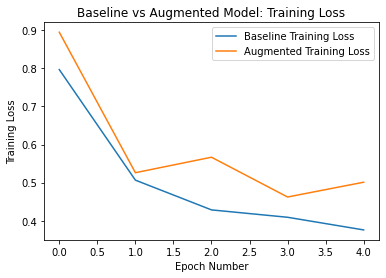

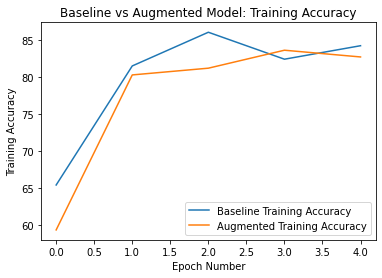

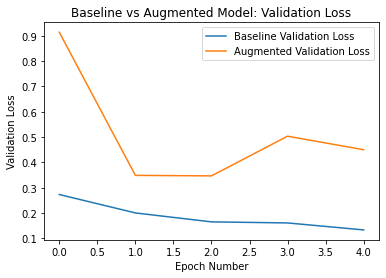

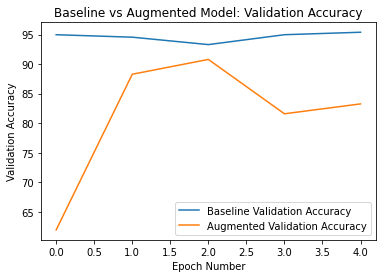

<Figure size 432x288 with 0 Axes>

In [11]:
# Compare training loss of augmented and baseline models
ds.plot_metric(NUM_OF_EPOCHS, loss_scores, loss_scores_conceptual, 'train', 'Loss')

# Compare training accuracy of augmented and baseline models
ds.plot_metric(NUM_OF_EPOCHS, accuracy_scores, accuracy_scores_conceptual, 'train', 'Accuracy')

# Compare validation loss of augmented and baseline models
ds.plot_metric(NUM_OF_EPOCHS, loss_scores, loss_scores_conceptual, 'val', 'Loss')

# Compare validation accuracy of augmented and baseline models
ds.plot_metric(NUM_OF_EPOCHS, accuracy_scores, accuracy_scores_conceptual, 'val', 'Accuracy')

# Model Selection

In [12]:
# Decide which model we want for the following steps

# Baseline model
model_ft.load_state_dict(torch.load(BASELINE_MODEL_PATH))
model_ft.to(device)
print("Loaded Baseline Model")

Loaded Baseline Model


In [13]:
# Augmented model
model_ft.load_state_dict(torch.load(CONCEPTUAL_MODEL_PATH))
model_ft.to(device)
print("Loaded Augmented Model")

Loaded Augmented Model


# Visualizing the TCAV Score

In [14]:
# Accuracy by class
ms.accuracy_by_class(model_ft, device, dataloaders, criterion, dataset_sizes, class_names)

val Loss: 0.3065 | Acc: 90.79%

Per Class Accuracy
Class name: ants | Acc: 90.00%
Class name: bees | Acc: 91.57%
Class name: zebra | Acc: 90.70%


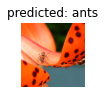

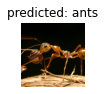

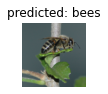

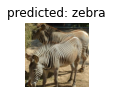

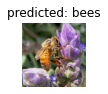

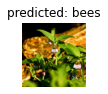

In [15]:
ms.visualize_model(model_ft, device=device, dataloaders=dataloaders, class_names=class_names)

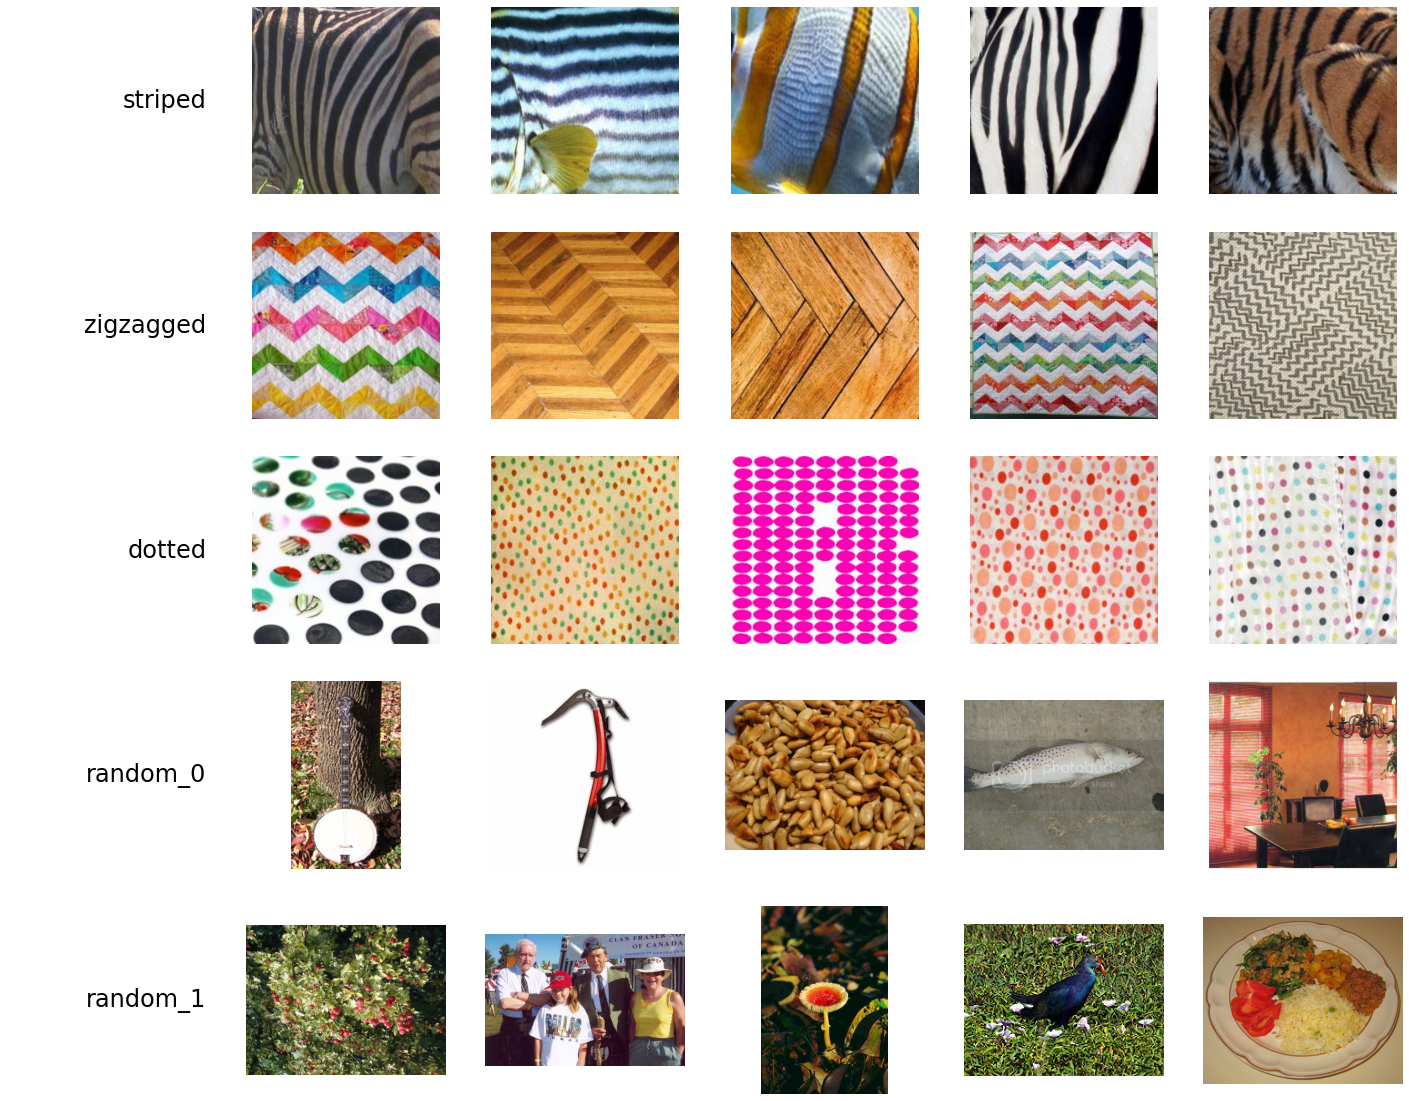

In [14]:
# Visualization of various concepts
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(CONCEPTS_PATH, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

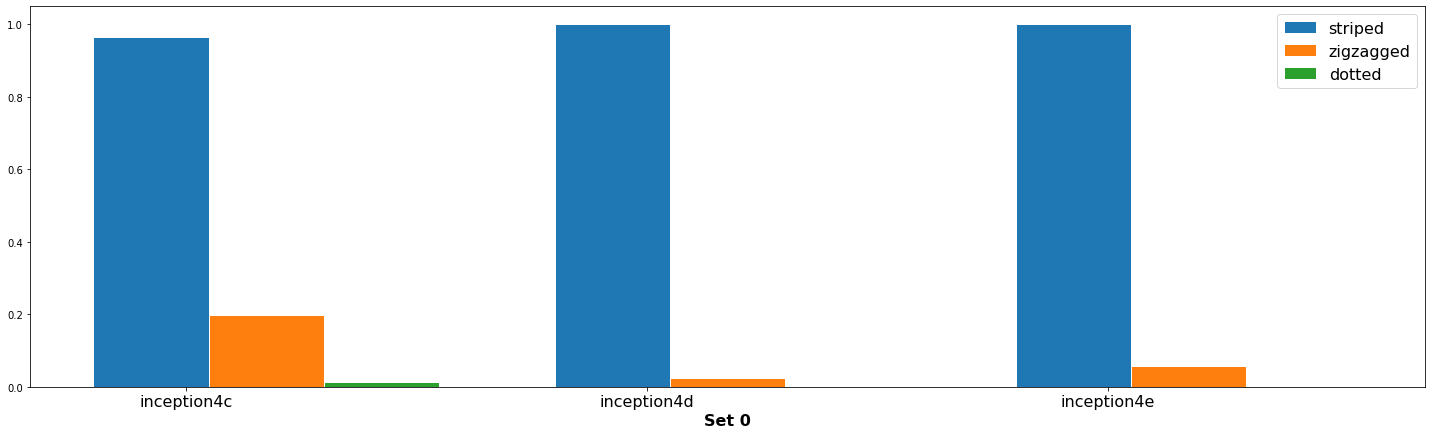

In [9]:
# Plot the TCAV scores

# Extract target class index.
target_class_idx = image_datasets['train'].class_to_idx[TARGET_CLASS]

# Load sample images from folder
path = os.path.join(DATA_DIR, 'val')
target_class_images = ds.load_image_tensors(TARGET_CLASS, root_path=path, transform=False)
target_class_tensors = torch.stack([ds.transform(img) for img in target_class_images])

# Send the model to the cpu
model_ft.cpu()

# Redefine the tcav on the model now on cpu
mytcav = TCAV(model=model_ft,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model_ft, None, multiply_by_inputs=False))

# Run TCAV
tcav_scores = mytcav.interpret(inputs=target_class_tensors,
                                         experimental_sets=experimental_sets,
                                         target=target_class_idx,
                                         n_steps=5)

ts.plot_tcav_scores(experimental_sets, tcav_scores, layers)

In [ ]:
# Visualization of classes

# Visualize some of the images
fig, axs = plt.subplots(1, 6, figsize = (25, 5))
axs[0].imshow(zebra_imgs[40])
axs[1].imshow(zebra_imgs[41])
axs[2].imshow(ant_imgs[34])
axs[3].imshow(ant_imgs[31])
axs[4].imshow(bee_imgs[30])
axs[5].imshow(bee_imgs[31])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')
axs[5].axis('off')

plt.show()